In [1]:
%load_ext autoreload
%autoreload 2

**INSTALLATION ISSUES**

There are lots of linking issues that occur if you have qt installed via Conda. I figured it out by uninstalling Qt and reinstalling the affected packages through `pip`. The reason is that CoppeliaSim needs a *very specific* version of `pip` in order to function.

Additionally, I found that my code would crash due to being "unable to load plugin 'xcb' even though it was found". To fix this, people [have found](https://github.com/NVlabs/instant-ngp/discussions/300) that you can set `QT_QPA_PLUGIN=offscreen` as an environment variable. This seemed to work for me, and it's what causes the kernel to die when using Jupyter without a desktop allocation on Rivanna. Note that you NEED to set this environment variable *when the server starts*.


In [4]:
"""
Approach: Similar to RVT.
Generate "virtual views" of a scene. Train a diffusion model to generate future keypoints or grasps with natural language guidance.
Will use a combination of CLIP and Segment Anything features.

Hopefully, should be amenable to massive multi-task learning with high accuracy, using only visual data.

Step 1. Dataset: Samples from RLBench. We will initially only use position, but quickly adopt towards rotation as well.

A case for ``simple" state space diffusion.

"""

# import cv2
import matplotlib.pyplot as plt
import torch

from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import JointVelocity
from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.tasks import OpenDrawer
from rlbench.observation_config import ObservationConfig

import torch
import torch.utils.data

# from voxel_renderer import VoxelRenderer

# Get some observations
env = Environment(
    MoveArmThenGripper(arm_action_mode=JointVelocity(), gripper_action_mode=Discrete()),
    '/scratch/gsk6me/RLBench_Data/train',
    obs_config=ObservationConfig(),
    headless=True)
env.launch()

task = env.get_task(OpenDrawer)

print("Getting demos...")
demos = task.get_demos(8, live_demos=False)

env.shutdown()


/sfs/weka/scratch/gsk6me/WORLDMODELS/rvt/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/sfs/weka/scratch/gsk6me/WORLDMODELS/rvt/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Getting demos...


# Making a Dataset for Keypoint Predictions

We will make previous observations "target" the end-effector position for future observations. From here, we can do behavioral cloning, which is just supervised learning. However, our goal is to be able to interpolate between a wide range of tasks through diffusion models and pretrained language models.

Note: For each Observation object, the `misc` attribute contains useful camera information (extrinsics, intrinsics, etc.)


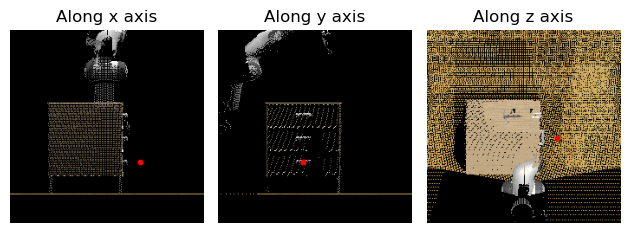

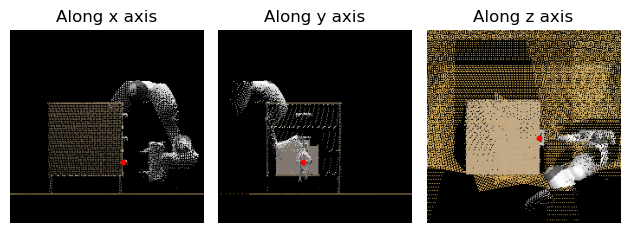

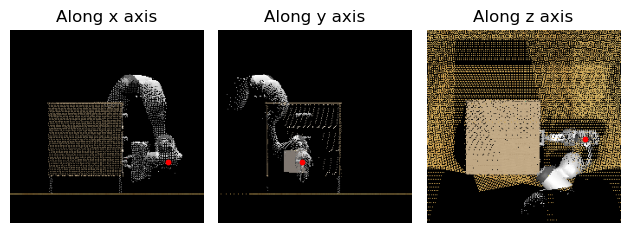

In [51]:
from demo_to_state_action_pairs import create_orthographic_labels
from voxel_renderer_slow import VoxelRenderer

def render_demo_keypoint_targets(demo):
    device = 'cuda'

    SCENE_BOUNDS = [
        -0.3, -0.5,
        0.6, 0.7,
        0.5, 1.6,
    ]
    VOXEL_IMAGE_SIZE = 224
    BACKGROUND_COLOR = torch.tensor([0, 0, 0], device=device)

    renderer = VoxelRenderer(SCENE_BOUNDS, VOXEL_IMAGE_SIZE, BACKGROUND_COLOR, device=device)
    for (images, positions) in create_orthographic_labels(demo, renderer, device="cuda"):
        plt.clf()

        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title("Along " + ('xyz'[i]) + " axis")
            
            image = images[i].cpu().numpy()
            position = positions[i]

            plt.imshow(image, origin='lower')
            plt.scatter(position[0], position[1], c='r', s=10)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

render_demo_keypoint_targets(demos[0])
